# Multiclass Classification
An intermediate solution beween regression and classification is classifying in chunks (i.e. good, medium, bad)

**NOTE**: For now, we are keeping the same classes as the upstream predictor system which is as follows:
1. <2wk = bad
2. 2wk-6wk = warning
3. \>6wk = good

## Steps
1. Segregate data into good medium bad. This way it can be used for ovo, ova, or multiclass classifier
2. Train multiclass classifier
3. ova
4. ovo

## Get Data
Get data in a format that is easier/more efficient to work with. e.g. only take columns that will be used for training, add rul column, etc

In [21]:
import os
import gc
import utils

import numpy as np

import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import confusion_matrix

from joblib import parallel_backend

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
pbar = ProgressBar()
pbar.register()
# client = Client()

In [4]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "date": "object",
    "serial_number": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32"
}

In [5]:
# read all the cleaned seagate data into one dataframe
DATA_DIR = "/home/kachauha/Downloads/data_Q4_2018_seagate_clean"
df = dd.read_csv(os.path.join(DATA_DIR, '*.csv'), dtype=custom_dtypes)

In [6]:
# define thresholds as timedelta
BAD_THRESHOLD_NDAYS = np.timedelta64(14, 'D')
WARNING_THRESHOLD_NDAYS = np.timedelta64(42, 'D')

### Get Failed Drives Data

In [7]:
# get the serial numbers for all the failed hard drives
failed_serials = df[df['failure']==1]['serial_number'].compute()

# failed drives data
failed_df = df[df['serial_number'].isin(failed_serials)]
failed_df.head()

[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed |  0.9s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
70,2018-10-01,S301GMGW,4.000787e+12,0.0,142208320.0,0.0,9.638218e+07,27453.0,0.0,0.0,...,100.0,100.0,76.0,28.0,24.0,100.0,100.0,100.0,100.0,100.0
640,2018-10-01,ZCH0CDHJ,1.200014e+13,0.0,84502232.0,0.0,4.777752e+08,5117.0,0.0,-100.0,...,100.0,-100.0,67.0,100.0,33.0,100.0,100.0,100.0,100.0,100.0
858,2018-10-01,ZA171RYT,8.001563e+12,0.0,97304432.0,72.0,3.140799e+09,12422.0,0.0,0.0,...,100.0,100.0,75.0,92.0,25.0,100.0,100.0,100.0,100.0,100.0
1291,2018-10-01,ZCH0C61J,1.200014e+13,0.0,80191024.0,0.0,8.444012e+08,6340.0,0.0,-100.0,...,100.0,-100.0,76.0,100.0,24.0,100.0,100.0,100.0,100.0,100.0
1601,2018-10-01,Z304KBTJ,4.000787e+12,0.0,224656896.0,0.0,2.613539e+08,25161.0,0.0,0.0,...,100.0,100.0,77.0,97.0,23.0,100.0,100.0,100.0,100.0,100.0


[########################################] | 100% Completed | 12.3s


(array([61., 45., 51., 54., 44., 53., 33.]),
 array([ 1., 14., 27., 40., 53., 66., 79., 92.]),
 <a list of 7 Patch objects>)

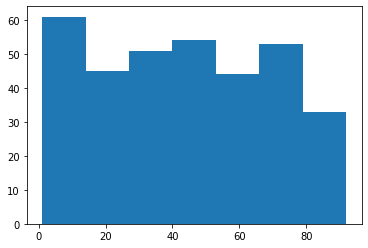

In [8]:
# number of days of data available for failed drives
days = failed_df[['date', 'serial_number', 'failure']].groupby('serial_number').size().compute()
plt.hist(days, bins=7)    # 92 days / 2 weeks = 7 bins

### Downsample Working Drives

In [9]:
# extract mean,std,capacity for working drives
working_feats_df = utils.featurize_ts(df[~df['serial_number'].isin(failed_serials)],
                                      drop_cols=['date', 'capacity_bytes', 'failure'])
working_feats_df.head()

[########################################] | 100% Completed | 43.1s


,mean_smart_1_raw,mean_smart_5_raw,mean_smart_7_raw,mean_smart_9_raw,mean_smart_10_raw,mean_smart_184_raw,mean_smart_187_raw,mean_smart_188_raw,mean_smart_189_raw,mean_smart_190_raw,...,std_smart_189_normalized,std_smart_190_normalized,std_smart_193_normalized,std_smart_194_normalized,std_smart_197_normalized,std_smart_198_normalized,std_smart_240_normalized,std_smart_241_normalized,std_smart_242_normalized,capacity_bytes
serial_number,,,,,,,,,,,,,,,,,,,,,
6VDHZ9H9,1.252961e+08,0.0,3.107040e+08,40928.739130,0.0,0.0,0.0,18.0,0.0,28.478261,...,0.0,0.714421,0.0,0.714421,0.0,0.0,0.0,0.0,0.0,3.200729e+11
6VDHZAKY,1.346626e+08,0.0,3.117690e+08,41365.304348,0.0,0.0,0.0,19.0,0.0,29.000000,...,0.0,1.215838,0.0,1.215838,0.0,0.0,0.0,0.0,0.0,3.200729e+11
6VDHZATY,2.070237e+08,0.0,4.240170e+08,41526.000000,0.0,0.0,0.0,8.0,0.0,25.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.200729e+11
6VDHZAXD,9.719883e+07,0.0,3.160235e+08,41275.187500,0.0,0.0,0.0,18.0,0.0,28.375000,...,0.0,1.727534,0.0,1.727534,0.0,0.0,0.0,0.0,0.0,3.200729e+11
6VDHZB48,1.047900e+08,0.0,3.157392e+08,41360.739130,0.0,0.0,0.0,14.0,0.0,30.130435,...,0.0,1.676029,0.0,1.676029,0.0,0.0,0.0,0.0,0.0,3.200729e+11


In [10]:
# apply clustering to get the serial numbers that best represent the working drives
working_repr_sers = utils.get_downsampled_working_sers(working_feats_df.compute())

# downsample the dataset
working_df = df[df['serial_number'].isin(working_repr_sers)]
working_df.head()

[########################################] | 100% Completed | 45.9s
[########################################] | 100% Completed |  0.9s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
413,2018-10-01,Z4D019KB,6.001175e+12,0.0,115227560.0,0.0,1.935556e+10,30709.0,0.0,0.0,...,100.0,78.0,72.0,2.0,28.0,100.0,100.0,100.0,100.0,100.0
1033,2018-10-01,Z4D032PG,6.001175e+12,0.0,118170800.0,0.0,6.201160e+10,30696.0,0.0,0.0,...,100.0,82.0,73.0,48.0,27.0,100.0,100.0,100.0,100.0,100.0
1064,2018-10-01,Z4D04BDA,6.001175e+12,0.0,63432688.0,0.0,4.048924e+10,30721.0,0.0,0.0,...,100.0,1.0,75.0,53.0,25.0,100.0,100.0,100.0,100.0,100.0
1108,2018-10-01,ZA12WYY1,8.001563e+12,0.0,227883360.0,0.0,3.891056e+09,16116.0,0.0,0.0,...,100.0,100.0,68.0,92.0,32.0,100.0,100.0,100.0,100.0,100.0
1229,2018-10-01,Z4D05J4J,6.001175e+12,0.0,73360216.0,0.0,1.975821e+09,30709.0,0.0,0.0,...,100.0,78.0,77.0,1.0,23.0,100.0,100.0,100.0,100.0,100.0


### Combine Failed and Working Drives
Even the combined data should be small enough since we have downsampled significantly. Therefore bring the combined df in memory so it is easier to work with

In [11]:
# concatenate rows
df = failed_df.append(working_df)
df.head()

[########################################] | 100% Completed |  0.9s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized
70,2018-10-01,S301GMGW,4.000787e+12,0.0,142208320.0,0.0,9.638218e+07,27453.0,0.0,0.0,...,100.0,100.0,76.0,28.0,24.0,100.0,100.0,100.0,100.0,100.0
640,2018-10-01,ZCH0CDHJ,1.200014e+13,0.0,84502232.0,0.0,4.777752e+08,5117.0,0.0,-100.0,...,100.0,-100.0,67.0,100.0,33.0,100.0,100.0,100.0,100.0,100.0
858,2018-10-01,ZA171RYT,8.001563e+12,0.0,97304432.0,72.0,3.140799e+09,12422.0,0.0,0.0,...,100.0,100.0,75.0,92.0,25.0,100.0,100.0,100.0,100.0,100.0
1291,2018-10-01,ZCH0C61J,1.200014e+13,0.0,80191024.0,0.0,8.444012e+08,6340.0,0.0,-100.0,...,100.0,-100.0,76.0,100.0,24.0,100.0,100.0,100.0,100.0,100.0
1601,2018-10-01,Z304KBTJ,4.000787e+12,0.0,224656896.0,0.0,2.613539e+08,25161.0,0.0,0.0,...,100.0,100.0,77.0,97.0,23.0,100.0,100.0,100.0,100.0,100.0


### Add RUL column
**NOTE**: RUL values make sense only for the failed drives, because they have been observed to fail. For working drives, actual failure time is unknown and therefore RUL values are not meaningful. For the purposes of this notebook, RUL is used only as a tool for processing/labelling data 

In [12]:
# convert from str to datetime
df['date'] = df['date'].astype('datetime64')

# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
df = df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [13]:
df.head()

[########################################] | 100% Completed | 18.2s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,rul_days
0,2018-10-08,Z3025LSR,4.000787e+12,0.0,211040928.0,0.0,597917120.0,35191.0,0.0,0.0,...,92.0,77.0,36.0,23.0,100.0,100.0,100.0,100.0,100.0,42 days
1,2018-10-04,Z3025LSR,4.000787e+12,0.0,180911520.0,0.0,595265536.0,35095.0,0.0,0.0,...,92.0,75.0,36.0,25.0,100.0,100.0,100.0,100.0,100.0,46 days
2,2018-10-17,Z3025LSR,4.000787e+12,0.0,146517808.0,0.0,602910720.0,35402.0,0.0,0.0,...,92.0,75.0,36.0,25.0,100.0,100.0,100.0,100.0,100.0,33 days
3,2018-10-12,Z3025LSR,4.000787e+12,0.0,170160672.0,0.0,600549184.0,35287.0,0.0,0.0,...,92.0,74.0,36.0,26.0,100.0,100.0,100.0,100.0,100.0,38 days
4,2018-10-13,Z3025LSR,4.000787e+12,0.0,31286256.0,0.0,601204352.0,35311.0,0.0,0.0,...,92.0,74.0,36.0,26.0,100.0,100.0,100.0,100.0,100.0,37 days


## Create Rolling Aggregates
Instead of having raw values in rows, use rolling aggregates of those values. This is closer to the setup we will have during inference time. Also, this will provide more data points because there will be multiple data points for a single hard drive.

It turns out that almost all the values being used as features are already simple rolling counts, and not instantaneous counts. The only instantaneous features are temperature related.

## Add Multiclass Labels
All data points will be treated as unique data points. Labels will be added according to rul. The numerical representation of labels are as follows:
1. 0 = good
2. 1 = warning
3. 2 = bad

In [14]:
# remove working drive data that is recorded after [quarter end minus 6 weeks]
# because we dont know (as of quarter end) if those drives survived more than 6 weeks or not
df = df[(df['serial_number'].isin(failed_serials)) | (df['rul_days'] >= WARNING_THRESHOLD_NDAYS)]
print(dd.compute(df.shape))
df.head()

[########################################] | 100% Completed | 23.0s
((29117, 39),)
[########################################] | 100% Completed | 16.9s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,rul_days
0,2018-10-08,Z3025LSR,4.000787e+12,0.0,211040928.0,0.0,597917120.0,35191.0,0.0,0.0,...,92.0,77.0,36.0,23.0,100.0,100.0,100.0,100.0,100.0,42 days
1,2018-10-17,Z3025LSR,4.000787e+12,0.0,146517808.0,0.0,602910720.0,35402.0,0.0,0.0,...,92.0,75.0,36.0,25.0,100.0,100.0,100.0,100.0,100.0,33 days
2,2018-10-04,Z3025LSR,4.000787e+12,0.0,180911520.0,0.0,595265536.0,35095.0,0.0,0.0,...,92.0,75.0,36.0,25.0,100.0,100.0,100.0,100.0,100.0,46 days
3,2018-10-12,Z3025LSR,4.000787e+12,0.0,170160672.0,0.0,600549184.0,35287.0,0.0,0.0,...,92.0,74.0,36.0,26.0,100.0,100.0,100.0,100.0,100.0,38 days
4,2018-10-13,Z3025LSR,4.000787e+12,0.0,31286256.0,0.0,601204352.0,35311.0,0.0,0.0,...,92.0,74.0,36.0,26.0,100.0,100.0,100.0,100.0,100.0,37 days


In [15]:
# NOTE: assignment must be done in this order otherwise it wont be correct. FIXME
# assign all as good initially
df['status'] = 0

# overwrite those which have rul less than 6 weeks as warning
df['status'] = df['status'].mask(df['rul_days'] < WARNING_THRESHOLD_NDAYS, 1)

# overwrite those which have rul less than 2 weeks as bad
df['status'] = df['status'].mask(df['rul_days'] < BAD_THRESHOLD_NDAYS, 2)

In [16]:
df.head()

[########################################] | 100% Completed | 16.9s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,rul_days,status
0,2018-10-04,Z3025LSR,4.000787e+12,0.0,180911520.0,0.0,595265536.0,35095.0,0.0,0.0,...,75.0,36.0,25.0,100.0,100.0,100.0,100.0,100.0,46 days,0
1,2018-10-17,Z3025LSR,4.000787e+12,0.0,146517808.0,0.0,602910720.0,35402.0,0.0,0.0,...,75.0,36.0,25.0,100.0,100.0,100.0,100.0,100.0,33 days,1
2,2018-10-08,Z3025LSR,4.000787e+12,0.0,211040928.0,0.0,597917120.0,35191.0,0.0,0.0,...,77.0,36.0,23.0,100.0,100.0,100.0,100.0,100.0,42 days,0
3,2018-10-12,Z3025LSR,4.000787e+12,0.0,170160672.0,0.0,600549184.0,35287.0,0.0,0.0,...,74.0,36.0,26.0,100.0,100.0,100.0,100.0,100.0,38 days,1
4,2018-10-13,Z3025LSR,4.000787e+12,0.0,31286256.0,0.0,601204352.0,35311.0,0.0,0.0,...,74.0,36.0,26.0,100.0,100.0,100.0,100.0,100.0,37 days,1


## Preprocess and Prepare

In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from dask_ml.preprocessing import RobustScaler as ddRobustScaler
from dask_ml.preprocessing import StandardScaler as ddStandardScaler
from dask_ml.model_selection import train_test_split as ddtrain_test_split

In [18]:
# bring into memory. this is likely not very big
X_df = df.drop(['date', 'serial_number', 'failure', 'rul_days', 'status'], axis=1).compute()
Y_df = df[['date', 'serial_number', 'failure', 'rul_days', 'status']].compute()

[########################################] | 100% Completed | 23.3s
[########################################] | 100% Completed | 22.1s


In [19]:
# treat as regular dataset and scale
# with parallel_backend('dask'):
scaler = RobustScaler()
X_df_scaled = scaler.fit_transform(X_df)

In [20]:
# split
# with parallel_backend('dask'):
# FIXME: dask_ml.train_test_split does not support stratified sampling. this could be dangerous
X_train, X_test, Y_train, Y_test = train_test_split(X_df_scaled, Y_df['status'], stratify=Y_df['status'])

## Establish Baseline

What would a baseline multiclass classifier look like? This can be found using a naive approach where drives are classified purely based on predefined/inferred thresholds.

Thresholds can be set in a variety of ways. A simple and naive way would be to involve all the covariates to determine the threshold boundary using their mean, or std, or max, or min values. Then, based some distance metric, drive can be classified.

In [22]:
# use mean values as threshold
class0_mean = X_train[(Y_train==0).values, :].mean(axis=0, keepdims=True)
class1_mean = X_train[(Y_train==1).values, :].mean(axis=0, keepdims=True)
class2_mean = X_train[(Y_train==2).values, :].mean(axis=0, keepdims=True)
class_means = np.vstack((class0_mean, class1_mean, class2_mean))

# predict based on a distance metric from mean values
# NOTE: canberra, cosine generally work better than l2,l1,etc
preds = pairwise_distances_argmin(X_test, class_means, metric='canberra')

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[2943,  426, 1282],
       [ 240,  389,  951],
       [ 176,  217,  656]])

array([[0.63276715, 0.09159321, 0.27563965],
       [0.15189873, 0.24620253, 0.60189873],
       [0.16777884, 0.20686368, 0.62535748]])

In [23]:
# use median values as threshold
class0_median = np.median(X_train[(Y_train==0).values, :], axis=0, keepdims=True)
class1_median = np.median(X_train[(Y_train==1).values, :], axis=0, keepdims=True)
class2_median = np.median(X_train[(Y_train==2).values, :], axis=0, keepdims=True)
class_medians = np.vstack((class0_median, class1_median, class2_median))

# predict based on a distance metric from median values
# NOTE: canberra, cosine generally work better than l2,l1,etc
preds = pairwise_distances_argmin(X_test, class_medians, metric='canberra')

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[3104, 1046,  501],
       [  95, 1029,  456],
       [  82,  646,  321]])

array([[0.66738336, 0.22489787, 0.10771877],
       [0.06012658, 0.65126582, 0.28860759],
       [0.07816969, 0.61582459, 0.30600572]])

In [24]:
# use min values as threshold
class0_min = X_train[(Y_train==0).values, :].min(axis=0, keepdims=True)
class1_min = X_train[(Y_train==1).values, :].min(axis=0, keepdims=True)
class2_min = X_train[(Y_train==2).values, :].min(axis=0, keepdims=True)
class_mins = np.vstack((class0_min, class1_min, class2_min))

# predict based on a distance metric from min values
# NOTE: canberra, cosine generally work better than l2,l1,etc
preds = pairwise_distances_argmin(X_test, class_mins, metric='cosine')

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[ 739,  725, 3187],
       [1005,  248,  327],
       [ 635,  168,  246]])

array([[0.15889056, 0.15588046, 0.68522898],
       [0.63607595, 0.15696203, 0.20696203],
       [0.60533842, 0.16015253, 0.23450906]])

In [25]:
# use max values as threshold
class0_max = X_train[(Y_train==0).values, :].max(axis=0, keepdims=True)
class1_max = X_train[(Y_train==1).values, :].max(axis=0, keepdims=True)
class2_max = X_train[(Y_train==2).values, :].max(axis=0, keepdims=True)
class_maxs = np.vstack((class0_max, class1_max, class2_max))

# predict based on a distance metric from max values
# NOTE: canberra, cosine generally work better than l2,l1,etc
# preds = pairwise_distances_argmin(X_test, class_maxs, metric='cosine')
class0_confs = (X_test > class0_max).sum(axis=1, keepdims=True)
class1_confs = (X_test > class1_max).sum(axis=1, keepdims=True)
class2_confs = (X_test > class2_max).sum(axis=1, keepdims=True)
class_confs = np.hstack((class0_confs, class1_confs, class2_confs))
preds = np.argmax(class_confs, axis=1)

# how does the baseline look
cm = confusion_matrix(Y_test, preds)
cm
cm / cm.sum(axis=1, keepdims=True)

array([[3844,  805,    2],
       [1579,    1,    0],
       [1036,   13,    0]])

array([[8.26488927e-01, 1.73081058e-01, 4.30015051e-04],
       [9.99367089e-01, 6.32911392e-04, 0.00000000e+00],
       [9.87607245e-01, 1.23927550e-02, 0.00000000e+00]])

**TODO**: groupby serial number then max value

## Train

### RGF

In [26]:
from rgf.sklearn import RGFClassifier

/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/kachauha/.local/share/virtualenvs/ceph_drive_failure-3-2yJKyM/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [27]:
# with parallel_backend('dask'):
rgf_clf = RGFClassifier(max_leaf=2500, l2=1e-12, learning_rate=0.01)
rgf_clf.fit(X_train, Y_train)

RGFClassifier(algorithm='RGF', calc_prob='sigmoid', init_model=None, l2=1e-12,
              learning_rate=0.01, loss='Log', max_leaf=2500,
              memory_policy='generous', min_samples_leaf=10, n_iter=None,
              n_jobs=-1, n_tree_search=1, normalize=False, opt_interval=100,
              reg_depth=1.0, sl2=None, test_interval=100, verbose=0)

In [39]:
utils.save_model(rgf_clf, "pretrained/rgf_multiclass")

In [28]:
# get preds as probabilities
rgf_prob_preds = rgf_clf.predict(X_test)
rgf_confmat_test = confusion_matrix(Y_test, rgf_prob_preds)
rgf_confmat_test
np.around(rgf_confmat_test / rgf_confmat_test.sum(axis=1, keepdims=True), decimals=2)

array([[4555,   93,    3],
       [  41, 1425,  114],
       [   3,  123,  923]])

array([[0.98, 0.02, 0.  ],
       [0.03, 0.9 , 0.07],
       [0.  , 0.12, 0.88]])